<a href="https://colab.research.google.com/github/jocelynprince1/YCBS258/blob/master/H6_JPrince_File_1_NLP_with_Universal_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - YCBS258 - Experimenting with NLP Tensorflow Hub modules

#### Submitted by Jocelyn Prince (2019/12/19)
---

# Sentiment Analysis Project - Post to Medium
#### NLP with the following Modules from Tensorflow Hub
* nnlm-en-dim128 Module
* Universal Sentence Encoder


### Description
Use some modules available in Tensorflow Hub to experiment NLP tasks.  Deploy a model on Google's AI-Platform (also called ML Engine) and demonstrate the model returning a prediction.

---------------

Details:
* Dataset for training: Sentiment140 (source: http://help.sentiment140.com/for-students/)

References:

* Prateek Joshi and his post: https://www.analyticsvidhya.com/blog/2019/03/learn-to-use-elmo-to-extract-features-from-text/

* https://arxiv.org/pdf/1802.05365.pdf

* https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/tf2_text_classification.ipynb#scrollTo=Eg62Pmz3o83v

* Aurélien Géron’s Book: hands-on Machine Learning with Scikit-Learn, Keras and Tensorflow, O’Reilly Media Inc.
-----

In [4]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 86.3MB 139kB/s 
     |████████████████████████████████| 3.8MB 41.8MB/s 
     |████████████████████████████████| 450kB 70.4MB/s 
     |████████████████████████████████| 81kB 13.3MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.9.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstall

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 7.0MB 2.8MB/s 
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import Libraries

In [2]:
# This Notebook needs to be executed under Python ≥3.5 and TensorFlow >= 2.0
import sys
assert sys.version_info >= (3, 5)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import optimizers
import tensorflow_hub as hub
assert tf.__version__ >= "2.0"

# Minimum Requirement for Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    !pip install -q -U tensorflow-addons
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if not tf.test.is_gpu_available():
    print("No GPU was detected. This code can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import time
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(20)
tf.random.set_seed(20)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Where to save the figures
PROJECT_ROOT_DIR = "."
FOLDER= "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", FOLDER)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

TensorFlow is already loaded. Please restart the runtime to change versions.


In [3]:
tf.__version__

'2.0.0'

In [4]:
import tensorflow as tf
tf.test.is_gpu_available()

True

In [5]:
# The spacy module needs to be installed
!pip install spacy

# The english module needs to be downloaded if not already
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
# Import other common libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
import itertools
import re
import spacy

# Import Dataset: Sentiment140 Tweets


In [0]:
trainfile = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/training.1600000.processed.noemoticon.csv"
testfile = "/content/drive/My Drive/Colab Notebooks/Final_Project/data/testdata.manual.2009.06.14.csv"
columns = ['polarity','id','date','query_string','twitter_user','tweet']

In [8]:
# Import Train data set
df_train = pd.read_csv(trainfile,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_train.shape

(1600000, 6)

In [9]:
# Import Test data set
df_test = pd.read_csv(testfile,
                 header=None, 
                 names=columns, 
                 encoding='latin-1')
df_test.shape

(498, 6)

# Data Preprocessing

## Explore Data

In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
polarity        1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
twitter_user    1600000 non-null object
tweet           1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
df_train.tweet[0:10]

0    @switchfoot http://twitpic.com/2y1zl - Awww, t...
1    is upset that he can't update his Facebook by ...
2    @Kenichan I dived many times for the ball. Man...
3      my whole body feels itchy and like its on fire 
4    @nationwideclass no, it's not behaving at all....
5                        @Kwesidei not the whole crew 
6                                          Need a hug 
7    @LOLTrish hey  long time no see! Yes.. Rains a...
8                 @Tatiana_K nope they didn't have it 
9                            @twittera que me muera ? 
Name: tweet, dtype: object

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7eb61a90>]],
      dtype=object)

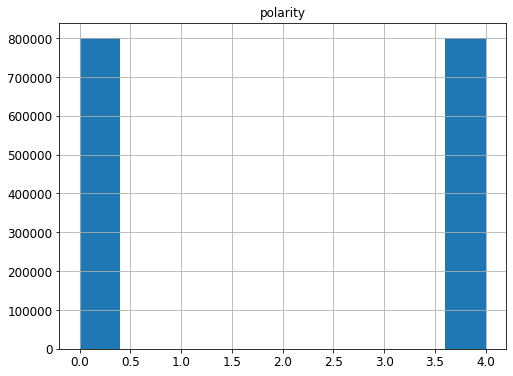

In [12]:
df_train.hist(["polarity"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd7e5b4198>]],
      dtype=object)

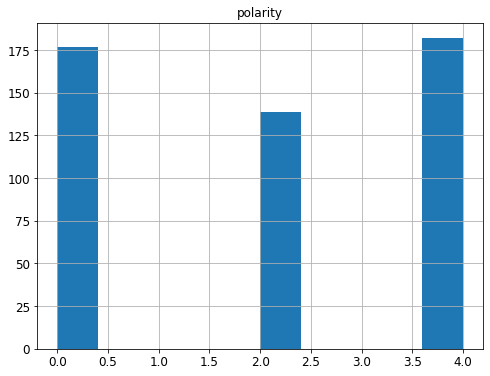

In [13]:
df_test.hist(["polarity"])

## Split Train and Test dataset


In [0]:
NUMTRAIN = 150000
NUMTEST = 3000
train_set = df_train[['id','polarity', 'tweet']].sample(NUMTRAIN)
test_set = df_train[['id','polarity', 'tweet']].sample(NUMTEST)

In [0]:
X_train = train_set.drop("polarity", axis=1) # drop labels for training set
y_train = train_set["polarity"].copy()

In [0]:
X_test = test_set.drop("polarity", axis=1) # drop labels for test set
y_test = test_set["polarity"].copy()

In [110]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 2)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 2)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [111]:
y_train.head()


1308464    4
496959     0
88434      0
165825     0
1328322    4
Name: polarity, dtype: int64

## Functions : Text-preprocessing and Lemmatize (Normalize) Tweets

In [0]:
def text_processing(tweet):
    # remove https links
    clean_tweet = re.sub(r'http\S+', '', tweet)
    # remove punctuation marks
    punctuation = '!"#$%&()*+-/:;<=>?@[\\]^_`{|}~'
    clean_tweet = ''.join(ch for ch in clean_tweet if ch not in set(punctuation))
    # convert text to lowercase
    clean_tweet = clean_tweet.lower()
    # remove numbers
    clean_tweet = re.sub('\d', ' ', clean_tweet)
    # remove whitespaces
    clean_tweet = ' '.join(clean_tweet.split())
    return clean_tweet

In [0]:
# import the english language model from spacy'
nlp = spacy.load('en', disable=['parser', 'ner'])
#nlp = spacy.load('en')

# function to lemmatize text
def lemmatization(tweets):
    lemma_tweet = []
    for i in tweets:
        t = [token.lemma_ for token in nlp(i)]
        lemma_tweet.append(' '.join(t))
    return lemma_tweet

In [0]:
X_train['clean_tweet'] = X_train['tweet'].apply(lambda x: text_processing(x))
X_test['clean_tweet'] = X_test['tweet'].apply(lambda x: text_processing(x))

In [113]:
X_train.head()

,id,tweet,clean_tweet
1308464,2012811208,sitting in the dark. Thinking of @JesseMcCartn...,sitting in the dark. thinking of jessemccartne...
496959,2185731498,Ouchy first skateboarding injury... haha not ...,ouchy first skateboarding injury... haha not t...
88434,1754869117,@indithunder wah sama ya huuuh yaudah deh ndi...,indithunder wah sama ya huuuh yaudah deh ndi t...
165825,1961063064,@CharPower I gave up cable in these tough eco...,charpower i gave up cable in these tough econo...
1328322,2015502338,i know what happens at the end of one tree hil...,i know what happens at the end of one tree hil...


In [114]:
# This is the cell to generate lemmatized files from the dataset
# We may also use already pre-processed files from google drive (see below)
%%time
X_train["clean_tweet"] = lemmatization(X_train["clean_tweet"])
X_test['clean_tweet'] = lemmatization(X_test['clean_tweet'])

# Expected time for 80 000 records (No Disabled): 11 min
# Expected time for 90 000 records (disabled : parser and ner): 4.5 min
# Expected time for 110 000 records (disabled : parser and ner): 4.5 min
# Expected time for 150 000 records (disabled : parser and ner): 6 min

CPU times: user 5min 56s, sys: 527 ms, total: 5min 57s
Wall time: 5min 57s


In [116]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 3)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 3)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [117]:
X_train.head()

,id,tweet,clean_tweet
1308464,2012811208,sitting in the dark. Thinking of @JesseMcCartn...,sit in the dark . think of jessemccartney and ...
496959,2185731498,Ouchy first skateboarding injury... haha not ...,ouchy first skateboard injury ... haha not to ...
88434,1754869117,@indithunder wah sama ya huuuh yaudah deh ndi...,indithunder wah sama ya huuuh yaudah deh ndi t...
165825,1961063064,@CharPower I gave up cable in these tough eco...,charpower i give up cable in these tough econo...
1328322,2015502338,i know what happens at the end of one tree hil...,i know what happen at the end of one tree hill...


In [118]:
X_test.head()

,id,tweet,clean_tweet
247846,1982567016,@MATTHARDYBRAND I love that palce but they don...,matthardybrand i love that palce but -PRON- do...
1132077,1975956651,@almcafee I'm glad you're enjoying it!,almcafee -PRON- be glad -PRON- be enjoy -PRON-
682915,2250132198,"Ugh, can't sleep, I think I have a big problem...","ugh , can not sleep , i think i have a big pro..."
35203,1565103664,wish the Blues would have won last night...,wish the blue would have win last night ...
549721,2202717423,..but Haagen-Dazs stopped selling chocolate pe...,.. but haagendazs stop sell chocolate peanut b...


In [119]:
y_train.head

<bound method NDFrame.head of 1308464    4
496959     0
88434      0
165825     0
1328322    4
          ..
1167526    4
198858     0
63562      0
314541     0
1560986    4
Name: polarity, Length: 150000, dtype: int64>

In [120]:
y_test.head

<bound method NDFrame.head of 247846     0
1132077    4
682915     0
35203      0
549721     0
          ..
1073006    4
1506242    4
1201862    4
754104     0
1361304    4
Name: polarity, Length: 3000, dtype: int64>

In [122]:
# Saved lemmatized files to Google Drive for further use

# Define file names and folder
PATH="/content/drive/My Drive/Colab Notebooks/Final_Project/data/"
X_train_lemma_file =  PATH + "X_train_lemma150k.csv"
X_test_lemma_file =   PATH + "X_test_lemma3k.csv"
y_train_lemma_file =  PATH + "y_train_lemma150k.csv"
y_test_lemma_file =   PATH + "y_test_lemma3k.csv"
print(X_train_lemma_file)

/content/drive/My Drive/Colab Notebooks/Final_Project/data/X_train_lemma150k.csv


In [0]:
# Save to files
X_train.to_csv(X_train_lemma_file, index=False)
X_test.to_csv(X_test_lemma_file, index=False)
y_train.to_csv(y_train_lemma_file, index=False, header=False)
y_test.to_csv(y_test_lemma_file, index=False, header=False)

In [0]:
# Import from files already pre-processed from Google Drive
X_train = pd.read_csv(X_train_lemma_file)
X_test = pd.read_csv(X_test_lemma_file)
y_train = pd.read_csv(y_train_lemma_file, squeeze=True, header=None)
y_test = pd.read_csv(y_test_lemma_file, squeeze=True, header=None)

In [125]:
X_train.head()

,id,tweet,clean_tweet
0,2012811208,sitting in the dark. Thinking of @JesseMcCartn...,sit in the dark . think of jessemccartney and ...
1,2185731498,Ouchy first skateboarding injury... haha not ...,ouchy first skateboard injury ... haha not to ...
2,1754869117,@indithunder wah sama ya huuuh yaudah deh ndi...,indithunder wah sama ya huuuh yaudah deh ndi t...
3,1961063064,@CharPower I gave up cable in these tough eco...,charpower i give up cable in these tough econo...
4,2015502338,i know what happens at the end of one tree hil...,i know what happen at the end of one tree hill...


In [126]:
X_test.head()

,id,tweet,clean_tweet
0,1982567016,@MATTHARDYBRAND I love that palce but they don...,matthardybrand i love that palce but -PRON- do...
1,1975956651,@almcafee I'm glad you're enjoying it!,almcafee -PRON- be glad -PRON- be enjoy -PRON-
2,2250132198,"Ugh, can't sleep, I think I have a big problem...","ugh , can not sleep , i think i have a big pro..."
3,1565103664,wish the Blues would have won last night...,wish the blue would have win last night ...
4,2202717423,..but Haagen-Dazs stopped selling chocolate pe...,.. but haagendazs stop sell chocolate peanut b...


In [127]:
y_train.head

<bound method NDFrame.head of 0         4
1         0
2         0
3         0
4         4
         ..
149995    4
149996    0
149997    0
149998    0
149999    4
Name: 0, Length: 150000, dtype: int64>

In [128]:
y_test.head

<bound method NDFrame.head of 0       0
1       4
2       0
3       0
4       0
       ..
2995    4
2996    4
2997    4
2998    0
2999    4
Name: 0, Length: 3000, dtype: int64>

In [129]:
print("X_train: " + str(X_train.shape) + str(type(X_train)))
print("y_train: "+ str(y_train.shape)+ str(type(y_train)))
print("X_test: " + str(X_test.shape) + str(type(X_test)))
print("y_test: "+ str(y_test.shape)+ str(type(y_test)))

X_train: (150000, 3)<class 'pandas.core.frame.DataFrame'>
y_train: (150000,)<class 'pandas.core.series.Series'>
X_test: (3000, 3)<class 'pandas.core.frame.DataFrame'>
y_test: (3000,)<class 'pandas.core.series.Series'>


In [0]:
X_train = X_train["clean_tweet"].values
X_test = X_test["clean_tweet"].values

In [131]:
print(X_train[0:5])

['sit in the dark . think of jessemccartney and -PRON- amazing friend katiespo and meghandriscoll . due to bein a proud jesse fan'
 'ouchy first skateboard injury ... haha not to be th last either ...'
 'indithunder wah sama ya huuuh yaudah deh ndi thankssss'
 'charpower i give up cable in these tough economic time . -PRON- be either cable or shoe , and -PRON- know what cable lose'
 'i know what happen at the end of one tree hill ... i see the episode picture . . yayyy']


## Label Encoding

In [132]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)                     
y_train[:5]

array([1, 0, 0, 0, 1])

In [0]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [135]:
y_train[0:5]

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [136]:
X_train.shape
# Should be (nb_of_records, )

(150000,)

In [137]:
y_test.shape

(3000, 2)

# Model nnlm-en-dim128

## Create Model using tf.hub: nnlm-en-dim128

In [188]:
MODEL = "nnlm-en-dim128"
VERSION = 2
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/nnlm-en-dim128/2


In [189]:
# Define the modle using Sequential api
hub_layer1 = hub.KerasLayer(URL, output_shape=[128], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer1)
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 124,659,458
Trainable params: 16,770
Non-trainable params: 124,642,688
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

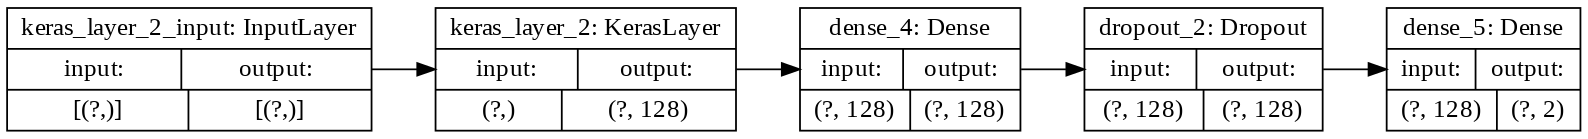

In [191]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                      show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [192]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40,
                 batch_size=128, 
                 validation_split=0.2,
                 verbose = 1)
# Benchmark time: 2 min per 10 epochs for 50 000 records/batch 32
# Benchmark time: 6 min per 25 epochs for 80 000 records/batch 32
# Benchmark time: 1.5 min per 15 epochs for 50 000 records/batch 64
# Benchmark time: 1.5 min per 15 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 1.5 min per 20 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 2 min per 30 epochs for 80 000 records/64 nodes/batch 64
# Benchmark time: 2.5  min per 30 epochs for 150 000 records/128 nodes/batch 128

Train on 120000 samples, validate on 30000 samples
Epoch 1/40
120000/120000 [==============================] - 5s 45us/sample - loss: 0.5635 - accuracy: 0.7090 - val_loss: 0.5401 - val_accuracy: 0.7258
Epoch 2/40
120000/120000 [==============================] - 5s 41us/sample - loss: 0.5387 - accuracy: 0.7292 - val_loss: 0.5327 - val_accuracy: 0.7319
Epoch 3/40
120000/120000 [==============================] - 5s 41us/sample - loss: 0.5310 - accuracy: 0.7348 - val_loss: 0.5277 - val_accuracy: 0.7349
Epoch 4/40
120000/120000 [==============================] - 5s 43us/sample - loss: 0.5266 - accuracy: 0.7384 - val_loss: 0.5254 - val_accuracy: 0.7371
Epoch 5/40
120000/120000 [==============================] - 5s 43us/sample - loss: 0.5228 - accuracy: 0.7412 - val_loss: 0.5232 - val_accuracy: 0.7383
Epoch 6/40
120000/120000 [==============================] - 5s 42us/sample - loss: 0.5206 - accuracy: 0.7433 - val_loss: 0.5197 - val_accuracy: 0.7409
Epoch 7/40
120000/120000 [=================

<function matplotlib.pyplot.show>

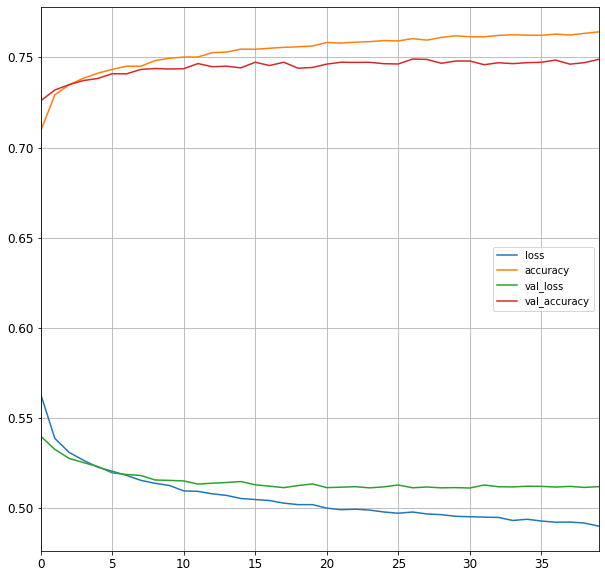

In [193]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model

In [194]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

3000/1 - 0s - loss: 0.6130 - accuracy: 0.7507
[0.5064963997205099, 0.7506667]


In [146]:
print(X_train[0:10])

['sit in the dark . think of jessemccartney and -PRON- amazing friend katiespo and meghandriscoll . due to bein a proud jesse fan'
 'ouchy first skateboard injury ... haha not to be th last either ...'
 'indithunder wah sama ya huuuh yaudah deh ndi thankssss'
 'charpower i give up cable in these tough economic time . -PRON- be either cable or shoe , and -PRON- know what cable lose'
 'i know what happen at the end of one tree hill ... i see the episode picture . . yayyy'
 'tired of the head game . -PRON- be so over -PRON- and -PRON-'
 'bad birthday ever' 'moobert hahaha ..... make a ws mix'
 'tryna kick -PRON- tomorrow , no ride though'
 'hcurri just in general this week']


## Confusion Matrix

In [0]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False,
                          title='CM', 
                          cmap=plt.cm.Greens):
# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix") # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45) 
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout() 
        plt.ylabel('True label') 
        plt.xlabel('Predicted label')

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded) 
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

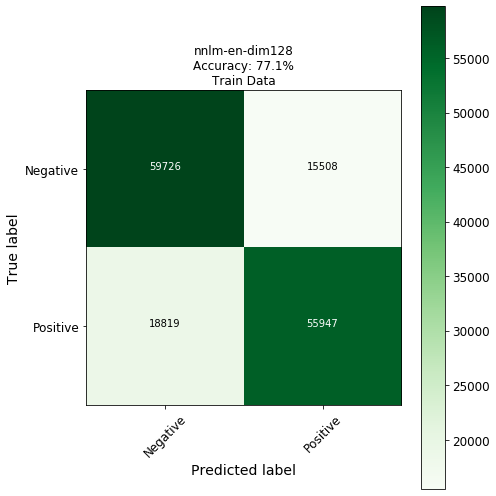

In [153]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data");

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

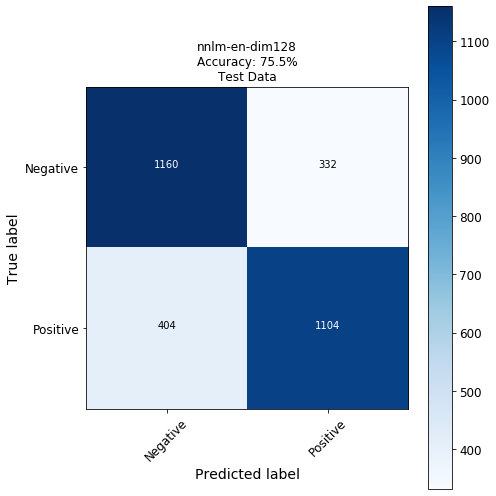

In [155]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Blues);

## Test the Model with some sentences

In [0]:
# Create input tweets for testing the sentiment model 
tweets = {'tweet':['Montreal is a nice city in the summer!!!',
                    'I have a good feeling about this team#11212',
                    'The show was not funny...',
                    'The dog is angry',
                    'The food at the restaurant could be better',
                    'The flight is a long one',
                    'It would be nice if the weather was better in Montreal *&&%&*&##!1',
                    'The Montreal hockey team will be making the playoffs',
                    'The weather in Montreal is very nice in the summer'
                   ],
          'sentiments':[4,
                       4,
                       0,
                       0,
                       0,
                       0,
                       0,
                       4,
                       4
                      ]
         } 
  
# Create DataFrame 
df_test = pd.DataFrame(tweets)

In [0]:
df_test['clean_tweet'] = df_test['tweet'].apply(lambda x: text_processing(x))

In [0]:
df_test["clean_tweet"] = lemmatization(df_test["clean_tweet"])

In [159]:
df_test

,tweet,sentiments,clean_tweet
0,Montreal is a nice city in the summer!!!,4,montreal be a nice city in the summer
1,I have a good feeling about this team#11212,4,i have a good feeling about this team
2,The show was not funny...,0,the show be not funny ...
3,The dog is angry,0,the dog be angry
4,The food at the restaurant could be better,0,the food at the restaurant could be well
5,The flight is a long one,0,the flight be a long one
6,It would be nice if the weather was better in ...,0,-PRON- would be nice if the weather be well in...
7,The Montreal hockey team will be making the pl...,4,the montreal hockey team will be make the playoff
8,The weather in Montreal is very nice in the su...,4,the weather in montreal be very nice in the su...


In [0]:
sentiments = df_test["sentiments"].copy()
label_encoder = LabelEncoder()
sentiments = label_encoder.fit_transform(sentiments)
sentiments = keras.utils.to_categorical(sentiments)

In [0]:
X_input = df_test["clean_tweet"].values

In [162]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [163]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Model Universal Sentence Encoder



## Create Model

In [164]:
MODEL = "universal-sentence-encoder"
VERSION = 4
URL = "https://tfhub.dev/google/"+MODEL+"/"+str(VERSION)
print (URL)

https://tfhub.dev/google/universal-sentence-encoder/4


In [165]:
hub_layer2 = hub.KerasLayer(URL, 
                           output_shape=[512], 
                           input_shape=[], 
                           dtype=tf.string
                          )
model = keras.Sequential()
model.add(hub_layer2)
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 256,830,786
Trainable params: 32,962
Non-trainable params: 256,797,824
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

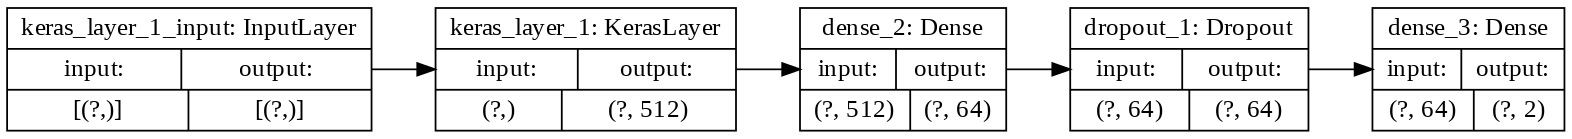

In [167]:
keras.utils.plot_model(model, 
                       #to_file='model.png',
                       show_shapes=True, show_layer_names=True, rankdir='LR', expand_nested=False, dpi=128)

## Execute Model

In [168]:
%%time
hist = model.fit(X_train, 
                 y_train, 
                 epochs=40, 
                 batch_size=128, 
                 validation_split=.2,
                 verbose = 1)
# Benchmark time: 21 min for 25 epochs/80 000 records/32 nodes/batch 32
# Benchmark time: 10 min for 12 epochs/80 000 records/32 nodes/batch 32
# Benchmark time: 6 min for 20 epochs/50 000 records/64 nodes/batch 64
# Benchmark time: 10 min for 30 epochs/80 000 records/64 nodes/batch 64
# Benchmark time: 7 min for 30 epochs/80 000 records/64 nodes/batch 128
# Benchmark time: 11 min for 40 epochs/150 000 records/128 nodes/batch 128

Train on 120000 samples, validate on 30000 samples
Epoch 1/40
120000/120000 [==============================] - 19s 159us/sample - loss: 0.5110 - accuracy: 0.7517 - val_loss: 0.4865 - val_accuracy: 0.7618
Epoch 2/40
120000/120000 [==============================] - 18s 146us/sample - loss: 0.4864 - accuracy: 0.7663 - val_loss: 0.4813 - val_accuracy: 0.7659
Epoch 3/40
120000/120000 [==============================] - 18s 146us/sample - loss: 0.4806 - accuracy: 0.7713 - val_loss: 0.4772 - val_accuracy: 0.7694
Epoch 4/40
120000/120000 [==============================] - 18s 147us/sample - loss: 0.4765 - accuracy: 0.7737 - val_loss: 0.4748 - val_accuracy: 0.7723
Epoch 5/40
120000/120000 [==============================] - 18s 148us/sample - loss: 0.4733 - accuracy: 0.7756 - val_loss: 0.4723 - val_accuracy: 0.7728
Epoch 6/40
120000/120000 [==============================] - 17s 145us/sample - loss: 0.4704 - accuracy: 0.7789 - val_loss: 0.4703 - val_accuracy: 0.7737
Epoch 7/40
120000/120000 [=====

<function matplotlib.pyplot.show>

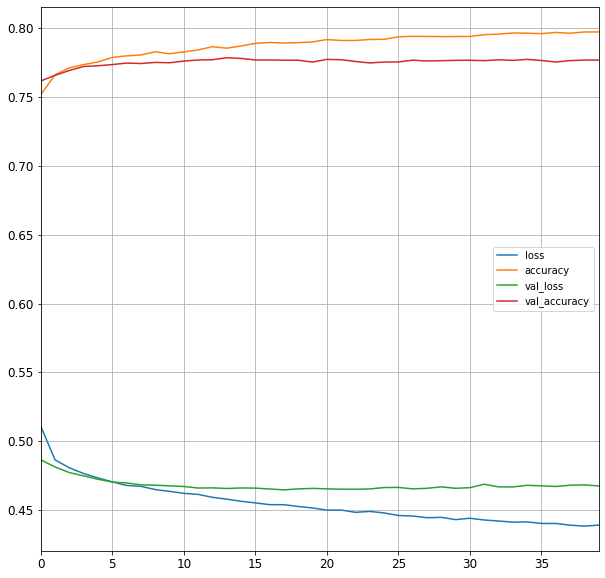

In [169]:
pd.DataFrame(hist.history).plot(figsize=(10,10))
plt.grid(True)
plt.show

## Evaluate Model Universal Sentence Encoder

In [170]:
accuracy_test = model.evaluate(X_test, y_test, verbose=2)
print(accuracy_test)

3000/1 - 1s - loss: 0.4635 - accuracy: 0.7713
[0.4659321711063385, 0.77133334]


In [171]:
print(X_train[0:10])

['sit in the dark . think of jessemccartney and -PRON- amazing friend katiespo and meghandriscoll . due to bein a proud jesse fan'
 'ouchy first skateboard injury ... haha not to be th last either ...'
 'indithunder wah sama ya huuuh yaudah deh ndi thankssss'
 'charpower i give up cable in these tough economic time . -PRON- be either cable or shoe , and -PRON- know what cable lose'
 'i know what happen at the end of one tree hill ... i see the episode picture . . yayyy'
 'tired of the head game . -PRON- be so over -PRON- and -PRON-'
 'bad birthday ever' 'moobert hahaha ..... make a ws mix'
 'tryna kick -PRON- tomorrow , no ride though'
 'hcurri just in general this week']


## Confusion Matrix

In [0]:
# np.argmax Returns the indices of the maximum values along an axis. 
y_test_rounded = np.argmax(y_test, axis=1)
y_train_rounded = np.argmax(y_train, axis=1)

In [0]:
y_pred = model.predict(X_train)
y_pred_rounded = np.argmax(y_pred, axis=1)

In [0]:
cmResults = confusion_matrix(y_train_rounded, y_pred_rounded)
accuracy = accuracy_score(y_train_rounded, y_pred_rounded)

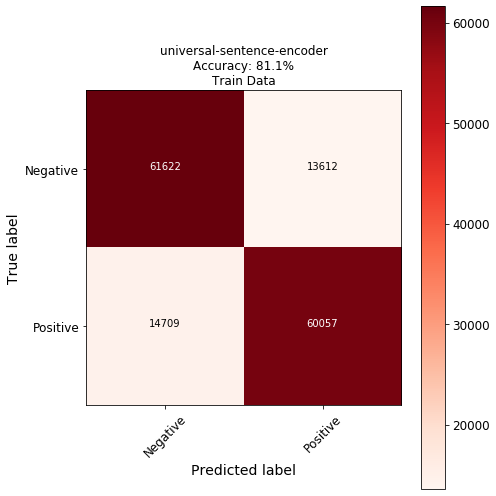

In [175]:
# Plot non-normalized confusion matrix 
class_names = ['Negative', 'Positive']
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Train Data",
                      cmap=plt.cm.Reds);

In [0]:
y_pred = model.predict(X_test)
y_pred_rounded = np.argmax(y_pred, axis=1)
cmResults = confusion_matrix(y_test_rounded, y_pred_rounded)
accuracy = accuracy_score(y_test_rounded, y_pred_rounded)

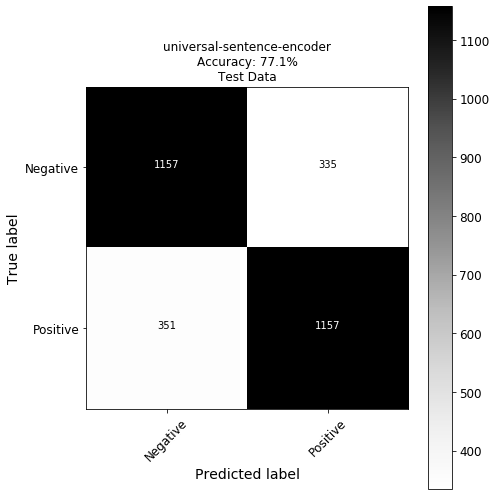

In [177]:
# Plot non-normalized confusion matrix 
plt.figure(figsize=(7,7));
plot_confusion_matrix(cmResults, classes=class_names, 
                      title=str(MODEL)+ "\n" +"Accuracy: " + str((accuracy*100).round(1)) + "%" +"\n"+"Test Data",
                      cmap=plt.cm.Greys);

## Test the Model with some sentences

In [178]:
X_input

array(['montreal be a nice city in the summer',
       'i have a good feeling about this team',
       'the show be not funny ...', 'the dog be angry',
       'the food at the restaurant could be well',
       'the flight be a long one',
       '-PRON- would be nice if the weather be well in montreal',
       'the montreal hockey team will be make the playoff',
       'the weather in montreal be very nice in the summer'], dtype=object)

In [179]:
print(model.predict(X_input).round(0))

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [180]:
model.predict(["It would be fun if the weather was nicer"])

array([[0.3471027 , 0.65289724]], dtype=float32)

In [181]:
print(sentiments)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


# Save Keras Model (nnlm-en-dim128)

In [195]:
# save model and architecture to single file
model_version = "0001"
model_name = "sentiment_analysis_dim128"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)
print("Saved model to disk")

INFO:tensorflow:Assets written to: sentiment_analysis_dim128/0001/assets


INFO:tensorflow:Assets written to: sentiment_analysis_dim128/0001/assets


Saved model to disk


## Copy Model to Google Storage (Bucket)

In [0]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()
else:
  %env GOOGLE_APPLICATION_CREDENTIALS ''

In [197]:
PROJECT_ID = "utopian-rush-255612" #@param {type:"string"}

# This must absolutely be a GLOBALLY UNIQUE name
BUCKET_NAME = "utopian-rush-255612-bucket_ml2" #@param {type:"string"}
REGION = "us-east1" #@param {type:"string"}

! gcloud config set project $PROJECT_ID
! echo $PROJECT_ID

Updated property [core/project].
utopian-rush-255612


In [185]:
# Create Bucket

! gsutil mb -p $PROJECT_ID -l $REGION gs://$BUCKET_NAME
# Display what is in the bucket
!gsutil ls -al gs://$BUCKET_NAME

Creating gs://utopian-rush-255612-bucket_ml2/...
ServiceException: 409 Bucket utopian-rush-255612-bucket_ml2 already exists.
                                 gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model/


In [0]:
JOB_DIR = 'gs://' + BUCKET_NAME + '/my_sentiment_analysis_model_dim128'

In [199]:
# Export the model to a local SavedModel directory 
# export_path = tf.contrib.saved_model.save_keras_model(model, 'keras_export')
# print("Model exported to: ", export_path)

# Export the model to a SavedModel directory in Cloud Storage
export_path = tf.saved_model.save(model, JOB_DIR + '/0001')
print("Model exported to: ", export_path)

INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model_dim128/0001/assets


INFO:tensorflow:Assets written to: gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model_dim128/0001/assets


Model exported to:  None


## Create the Model in the AI Platform

In [201]:
MODEL_NAME = "sa_final_project_dim128"

! gcloud ai-platform models create $MODEL_NAME --regions $REGION

Created ml engine model [projects/utopian-rush-255612/models/sa_final_project_dim128].


## Create the Version of the Model in AI Platform

In [0]:
! gcloud ai-platform versions create v1 \
  --model $MODEL_NAME \
  --runtime-version 1.14 \
  --python-version 3.5 \
  --framework tensorflow \
  --origin gs://utopian-rush-255612-bucket_ml2/my_sentiment_analysis_model_dim128/0001/